This notebook plots the number of shared k-mers between UC, CD, and nonIBD for dominating set pieces that are increased in abundance in CD and decreased in abundance in CD. 

+ X GCF_002234575.2--s__Enterocloster_bolteae.sig 605 605
+ X GCF_900113155.1--s__Enterocloster_clostridioformis 604 604
+ X GCF_000424325.1--s__Enterocloster_clostridioformis_A 605 604
+ X GCF_005845215.1--s__Enterocloster_sp005845215.sig 605 605
+ X GCF_008121495.1--s__Ruminococcus_B_gnavus.sig   605 604

In [1]:
setwd("..")

In [3]:
library(readr)
library(tidyr)
library(ggplot2)
library(dplyr)
library(UpSetR)

### functions

In [4]:
overlapGroups <- function (listInput, sort = TRUE) {
  # listInput could look like this:
  # $one
  # [1] "a" "b" "c" "e" "g" "h" "k" "l" "m"
  # $two
  # [1] "a" "b" "d" "e" "j"
  # $three
  # [1] "a" "e" "f" "g" "h" "i" "j" "l" "m"
  listInputmat    <- fromList(listInput) == 1
  #     one   two three
  # a  TRUE  TRUE  TRUE
  # b  TRUE  TRUE FALSE
  #...
  # condensing matrix to unique combinations elements
  listInputunique <- unique(listInputmat)
  grouplist <- list()
  # going through all unique combinations and collect elements for each in a list
  for (i in 1:nrow(listInputunique)) {
    currentRow <- listInputunique[i,]
    myelements <- which(apply(listInputmat,1,function(x) all(x == currentRow)))
    attr(myelements, "groups") <- currentRow
    grouplist[[paste(colnames(listInputunique)[currentRow], collapse = "_")]] <- myelements
    myelements
    # attr(,"groups")
    #   one   two three 
    # FALSE FALSE  TRUE 
    #  f  i 
    # 12 13 
  }
  if (sort) {
    grouplist <- grouplist[order(sapply(grouplist, function(x) length(x)), decreasing = TRUE)]
  }
  attr(grouplist, "elements") <- unique(unlist(listInput))
  return(grouplist)
  # save element list to facilitate access using an index in case rownames are not named
}


### metadata

In [5]:
metadata <- read_tsv("inputs/working_metadata.tsv", show_col_types = F) %>%
  select(library_name, study_accession, diagnosis) %>%
  distinct()

In [6]:
acc_to_species <- read_csv("outputs/genbank/gather_vita_vars_gtdb_shared_assemblies.x.genbank.lineages.csv",
                           col_names = c("accession", "kingdom", "phylum", "class",
                                         "order", "family", "genus", "species"), show_col_types = F) %>%
  select(accession, species) %>%
  mutate(accession = gsub("_genomic.fna.gz", "", accession))

### plot all increased

In [7]:
# read in all increased in abundance DFs, format as upset DF, and label with metadata
files <- Sys.glob("outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/*CD_increased.csv")
all_upset_df_increased <- data.frame()
all_li_increased <- data.frame()
for(i in 1:length(files)){
  file <- files[i]
  print(file)
  acc_string <- gsub("outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/", "", file)
  acc_string <- gsub("_CD_increased.csv", "", acc_string)

  sketch_table <- read_csv(file, show_col_types = F) 
  if(ncol(sketch_table) > 1){ 
    sketch_table <- sketch_table %>%
      select(minhash, acc, library_name) %>%
      mutate(acc = gsub("_CD_increased", "", acc)) %>%
      mutate(library_name = gsub("outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect/", "", library_name),
             library_name = gsub(paste0("/", acc_string, "_CD_increased.csv"), "", library_name)) %>% 
      left_join(metadata, by = "library_name")
    
    uc <- filter(sketch_table, diagnosis == "UC")$minhash
    cd <- filter(sketch_table, diagnosis == "CD")$minhash
    nonibd <- filter(sketch_table, diagnosis == "nonIBD")$minhash
    upset_list <- list(UC = uc, CD = cd, nonIBD = nonibd)
    upset_df <- fromList(upset_list)
    # add metadata for plotting
    upset_df <- upset_df %>%
      mutate(accession = acc_string, 
             abundance = "increased") %>%
      left_join(acc_to_species, by = c("accession")) 
    
    all_upset_df_increased <- bind_rows(all_upset_df_increased, upset_df)
    
    # get number per intersection per accession
    li <- overlapGroups(upset_list)
    li <- purrr::map(li, ~ attr(li, "elements")[.x] )
    set_sizes <- sapply(li, length)
    li2 <- data.frame(intersection = names(set_sizes),
                      intersection_size = set_sizes) %>%
      mutate(accession = sketch_table$acc[1]) %>%
      pivot_wider(id_cols = accession, names_from = intersection, values_from = intersection_size)
    all_li_increased <- bind_rows(all_li_increased, li2)
  }
}

[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_003447295.1_CD_increased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_014337175.1_CD_increased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900539885.1_CD_increased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900539945.1_CD_increased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900545925.1_CD_increased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900554435.1_CD_increased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900556635.1_CD_increased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900557055.1_CD_increased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900758315.1_CD_increas

In [8]:
# make a vector to color by,  where all species except the 5 more abundant ones are grey
more_abund_species <- c("s__Ruminococcus_B gnavus", "s__Enterocloster bolteae",
                        "s__Enterocloster clostridioformis_A", "s__Enterocloster sp005845215",
                        "s__Enterocloster clostridioformis")
all_upset_df_increased$species2 <- ifelse(all_upset_df_increased$species %in% more_abund_species, all_upset_df_increased$species, "other")
all_upset_df_increased$species2 <- gsub("s__", "", all_upset_df_increased$species2)
all_upset_df_increased$species2 <- factor(all_upset_df_increased$species2, 
                                          levels = c("Enterocloster bolteae",
                                                     "Enterocloster clostridioformis_A",
                                                     "Enterocloster clostridioformis",
                                                     "Enterocloster sp005845215",
                                                     "Ruminococcus_B gnavus",
                                                     "other"))

In [17]:
# extra color hex code: 
library(ComplexUpset)
diagnosis = c("UC", "CD", "nonIBD")
plt_increased <- ComplexUpset::upset(all_upset_df_increased, diagnosis, sort_intersections_by='cardinality',
                    set_sizes=FALSE, name=NULL, width_ratio = 0.1,
                    base_annotations=list(
                      'number of k-mers'=intersection_size(
                        counts=FALSE,
                        mapping=aes(fill=species2)) 
                      + scale_fill_manual(values=c("Enterocloster bolteae" = "#018571",
                                                   "Enterocloster clostridioformis_A" =  "#80CDC1",
                                                   "Enterocloster clostridioformis" = "#4DAC26",
                                                   "Enterocloster sp005845215" = "#B8E186",
                                                   "Ruminococcus_B gnavus" = "#B2ABD2",
                                                   "other" = "#595959"),
                                          name = "species") +
                        theme_classic() +
                        theme(axis.text.x = element_blank(),
                              axis.title.x = element_blank(),
                              axis.ticks.x = element_blank(),
                              legend.text = element_text(face = "italic", size = 7),
                              legend.title = element_text(size = 9)))) +
  theme(panel.grid = element_blank())

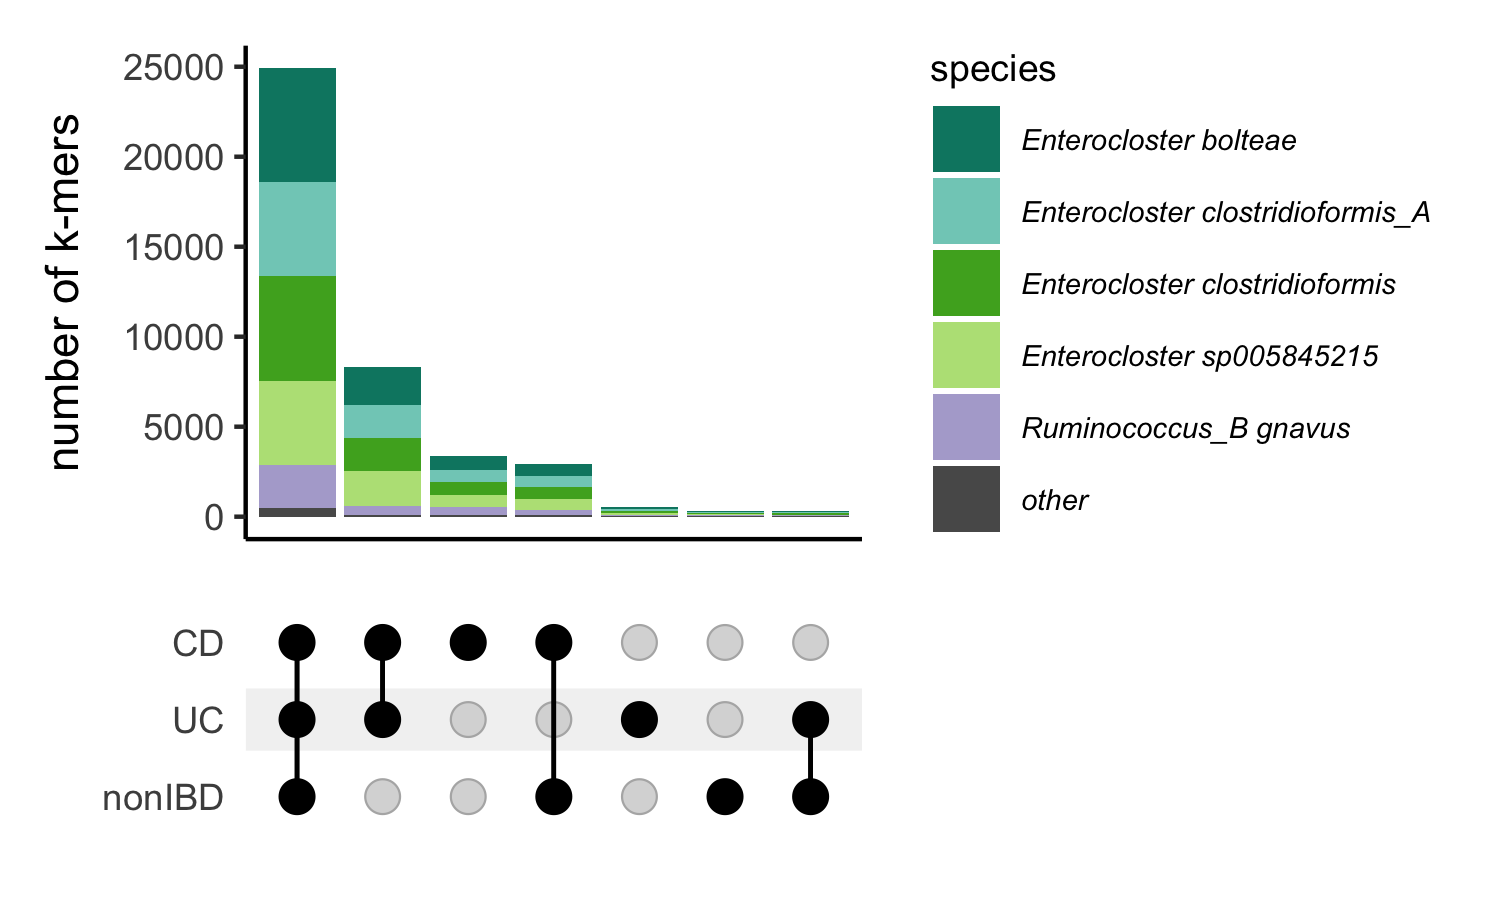

In [20]:
# adjust plot size rendered inline
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)

#pdf("figures/dda_kmers_shared_across_diagnosis_upset_increased.pdf", height = 3, width = 5)
plt_increased
#dev.off()

#png("figures/dda_kmers_shared_across_diagnosis_upset_increased.png", height = 3, width = 5, units= "in", res = 300)
#plt_increased
#dev.off()

### plot all decreased

In [21]:
# read in all increased in abundance DFs, format as upset DF, and label with metadata
files <- Sys.glob("outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/*CD_decreased.csv")
all_upset_df_decreased <- data.frame()
all_li_decreased <- data.frame()
for(i in 1:length(files)){
  file <- files[i]
  print(file)
  acc_string <- gsub("outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/", "", file)
  acc_string <- gsub("_CD_decreased.csv", "", acc_string)
  
  sketch_table <- read_csv(file, show_col_types = F) 
  if(ncol(sketch_table) > 1){ 
    sketch_table <- sketch_table %>%
      select(minhash, acc, library_name) %>%
      mutate(acc = gsub("_CD_decreased", "", acc)) %>%
      mutate(library_name = gsub("outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect/", "", library_name),
             library_name = gsub(paste0("/", acc_string, "_CD_decreased.csv"), "", library_name)) %>% 
      left_join(metadata, by = "library_name")
    
    uc <- filter(sketch_table, diagnosis == "UC")$minhash
    cd <- filter(sketch_table, diagnosis == "CD")$minhash
    nonibd <- filter(sketch_table, diagnosis == "nonIBD")$minhash
    upset_list <- list(UC = uc, CD = cd, nonIBD = nonibd)
    upset_df <- fromList(upset_list)
    # add metadata for plotting
    upset_df <- upset_df %>%
      mutate(accession = acc_string, 
             abundance = "increased") %>%
      left_join(acc_to_species, by = c("accession")) 
    
    all_upset_df_decreased <- bind_rows(all_upset_df_decreased, upset_df)
    
    # get number per intersection per accession
    li <- overlapGroups(upset_list)
    li <- purrr::map(li, ~ attr(li, "elements")[.x] )
    set_sizes <- sapply(li, length)
    li2 <- data.frame(intersection = names(set_sizes),
                      intersection_size = set_sizes) %>%
      mutate(accession = sketch_table$acc[1]) %>%
      pivot_wider(id_cols = accession, names_from = intersection, values_from = intersection_size)
    all_li_decreased <- bind_rows(all_li_decreased, li2)
  }
}

[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_000210075.1_CD_decreased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_003447295.1_CD_decreased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_014337175.1_CD_decreased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900539885.1_CD_decreased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900539945.1_CD_decreased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900545925.1_CD_decreased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900554435.1_CD_decreased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900556635.1_CD_decreased.csv"
[1] "outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_intersect_long/GCA_900557055.1_CD_decreas

In [22]:
diagnosis = c("UC", "CD", "nonIBD")
plt_decreased <- ComplexUpset::upset(all_upset_df_decreased, diagnosis, sort_intersections_by='cardinality',
                    set_sizes=FALSE, name=NULL, width_ratio = 0.1,
                    base_annotations=list(
                      'number of k-mers'=intersection_size(counts=FALSE) +
                        theme_classic() +
                        theme(axis.text.x = element_blank(),
                              axis.title.x = element_blank(),
                              axis.ticks.x = element_blank()) + 
                        ylim(0, 600000))) +
  theme(panel.grid = element_blank())

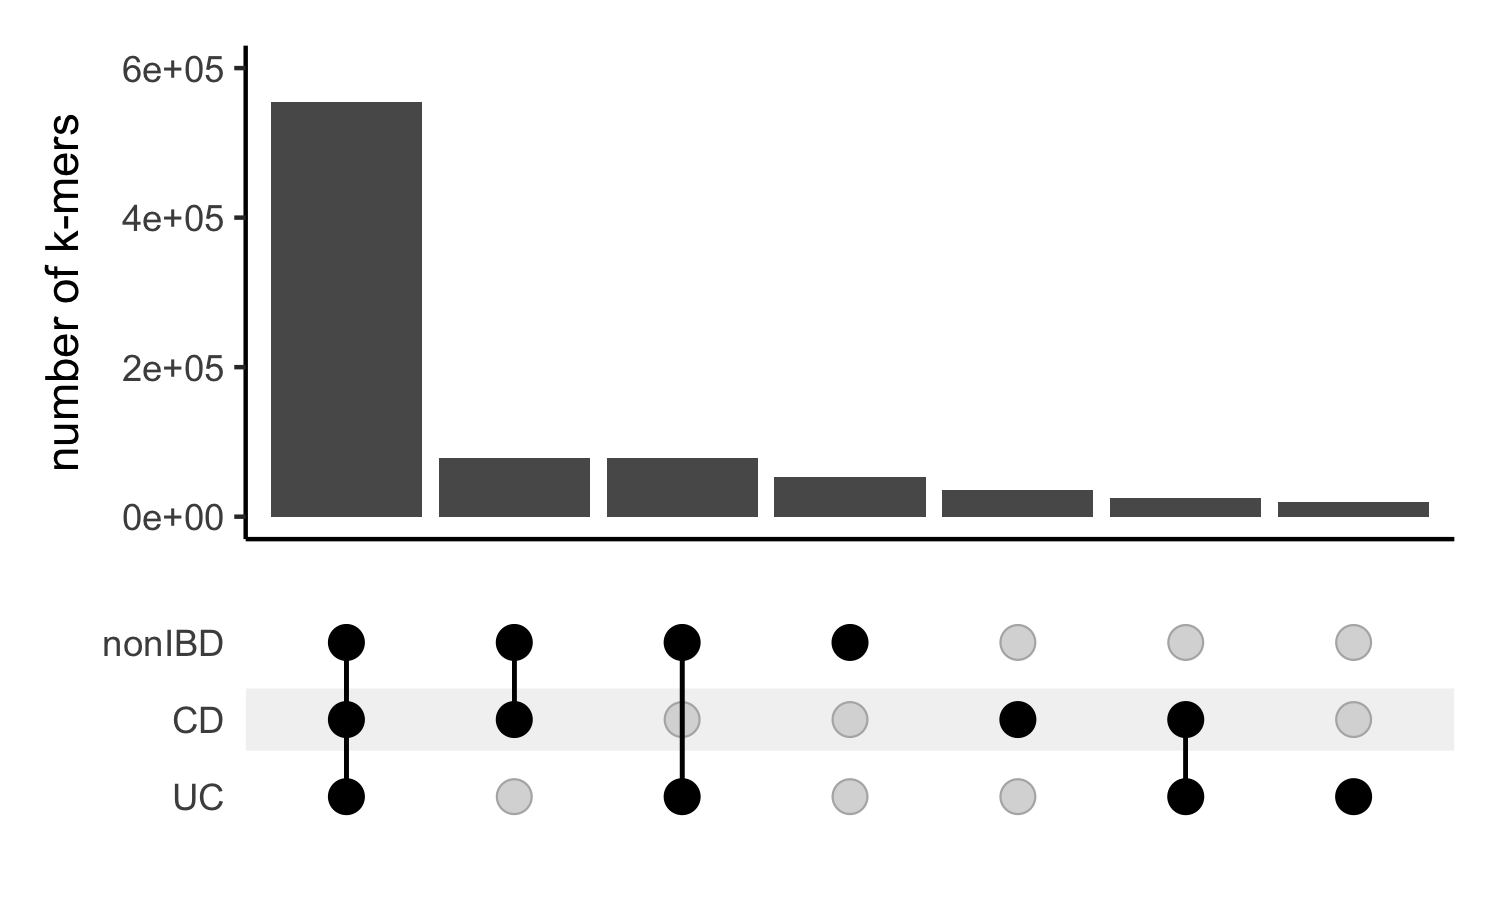

In [25]:
#pdf("figures/dda_kmers_shared_across_diagnosis_upset_decreased_supplemental.pdf", height = 3, width = 4)
plt_decreased
#dev.off()

#png("figures/dda_kmers_shared_across_diagnosis_upset_decreased_supplemental.png", height = 3, width = 4, units= "in", res = 300)
#plt_decreased
#dev.off()

### determine number DDA per species unobserved in each condition

In [20]:
all_li_increased[is.na(all_li_increased)] <- 0

In [21]:
tmp <- all_li_increased %>%
  pivot_longer(cols = -accession, names_to = "intersection", values_to = "n_kmers")

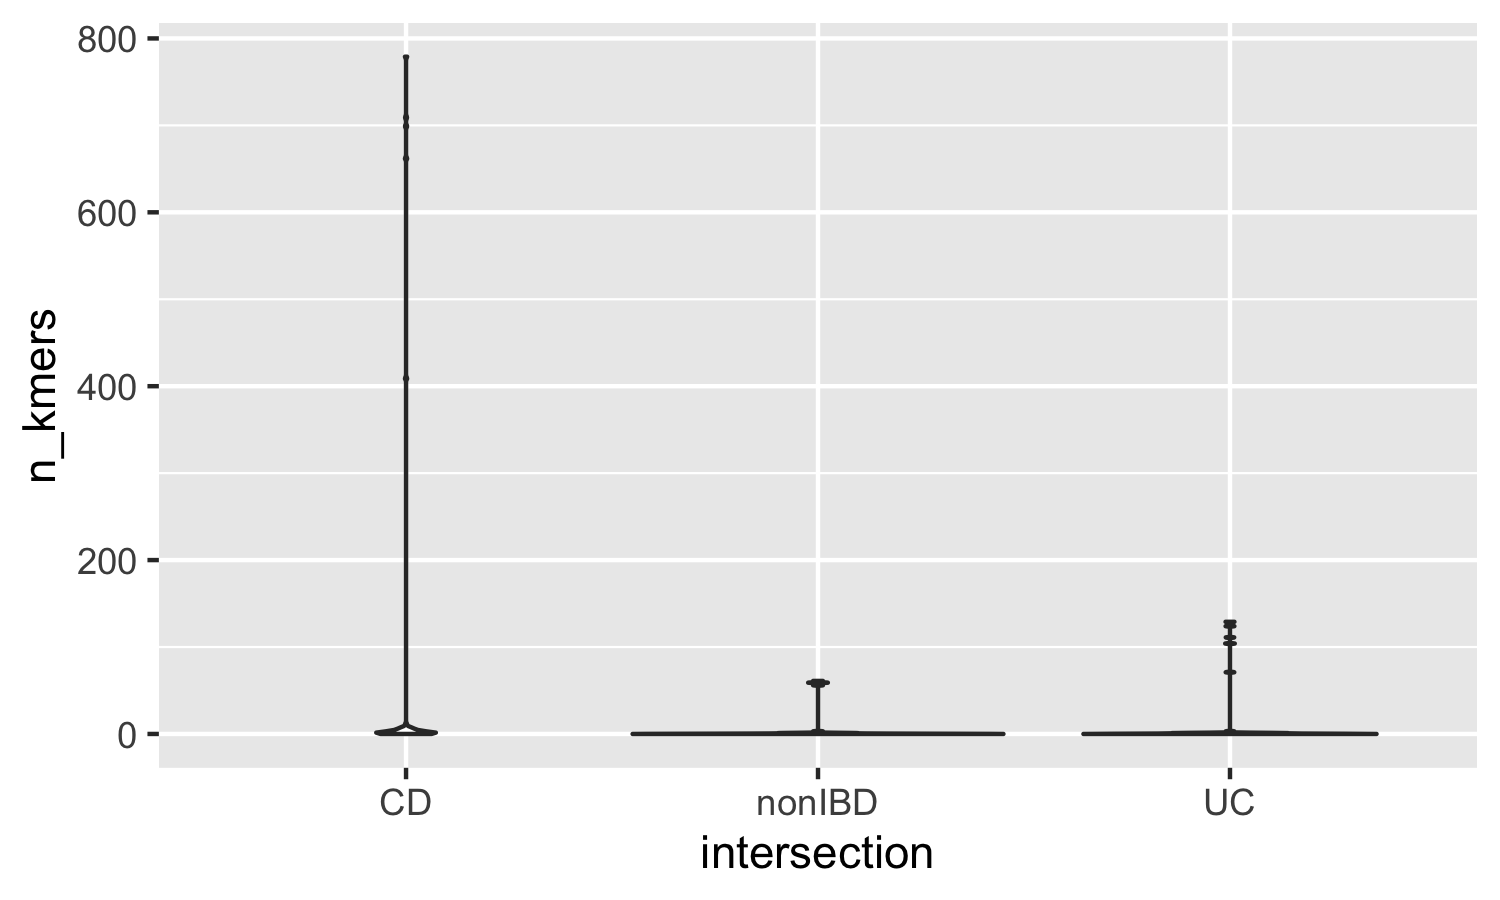

In [22]:
ggplot(tmp %>%
         filter(intersection %in% c("CD", "UC", "nonIBD")), 
       aes(x = intersection, y = n_kmers)) +
  geom_violin()

In [23]:
total_df <- tmp %>%
  group_by(accession) %>%
  summarize(total_kmers = sum(n_kmers))
head(total_df)

accession,total_kmers
<chr>,<dbl>
GCA_003447295.1,19
GCA_014337175.1,26
GCA_900539885.1,1
GCA_900539945.1,3
GCA_900545925.1,6
GCA_900554435.1,3


In [24]:
tmp2 <- tmp %>%
  filter(intersection %in% c("CD", "UC", "nonIBD")) %>%
  group_by(accession) %>%
  summarize(n_kmers_in_one_diagnosis = sum(n_kmers)) %>%
  left_join(total_df)
mean(tmp2$n_kmers_in_one_diagnosis/tmp2$total_kmers)
mean(tmp2$n_kmers_in_one_diagnosis)
mean(tmp2$total_kmers)

Joining, by = "accession"


[1] 0.166239

[1] 81.28846

[1] 783.3846

In [25]:
tmp <- all_li_decreased %>%
  pivot_longer(cols = -accession, names_to = "intersection", values_to = "n_kmers")

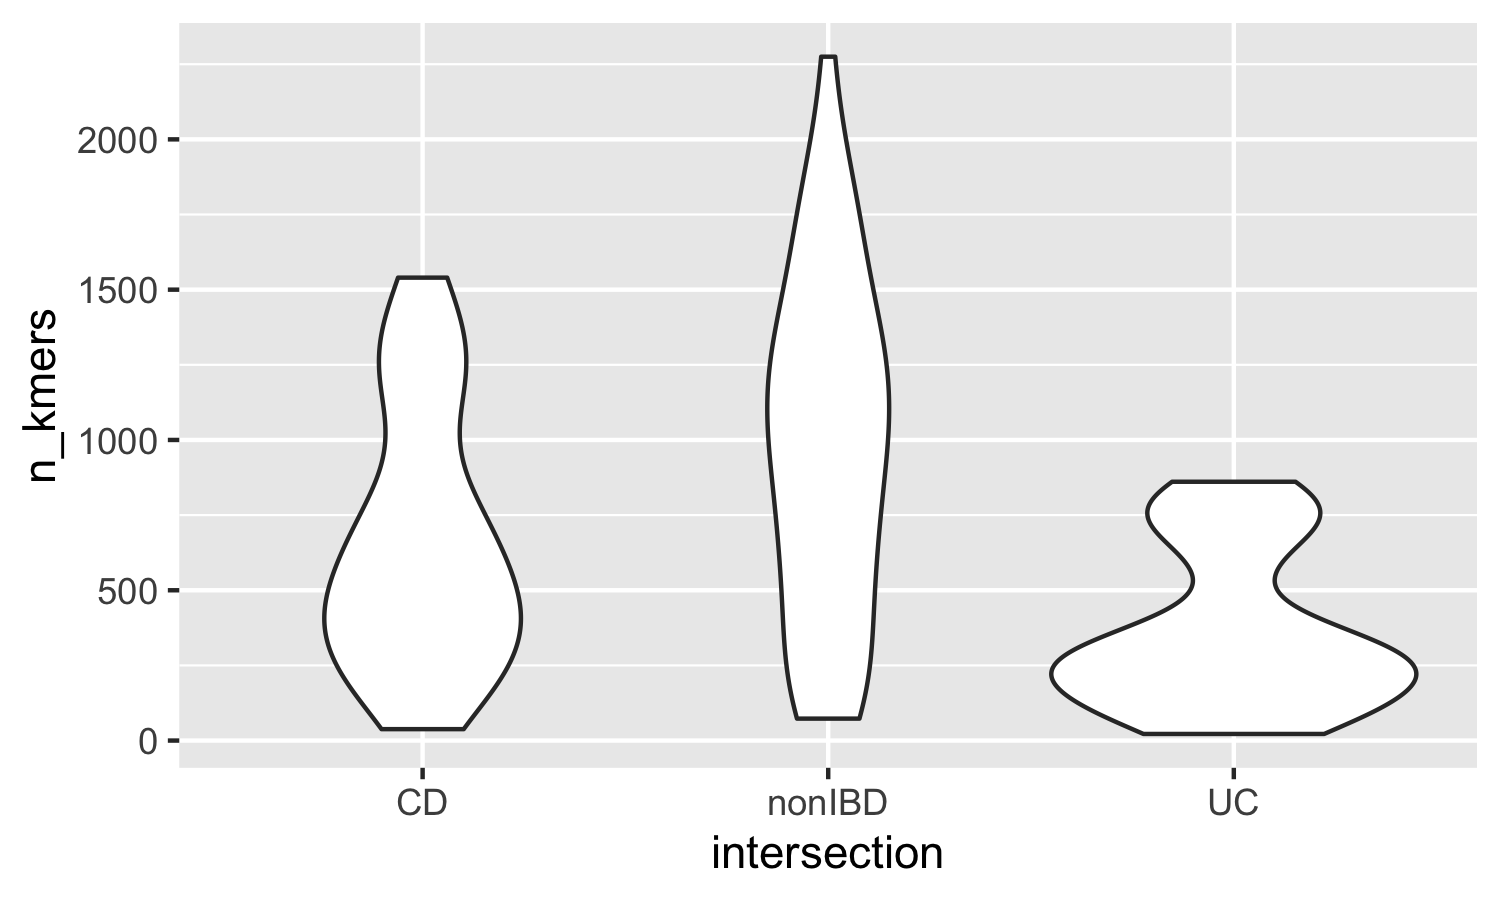

In [26]:
ggplot(tmp %>%
         filter(intersection %in% c("CD", "UC", "nonIBD")), 
       aes(x = intersection, y = n_kmers)) +
  geom_violin()

In [27]:
total_df <- tmp %>%
  group_by(accession) %>%
  summarize(total_kmers = sum(n_kmers))
head(total_df)

accession,total_kmers
<chr>,<int>
GCA_000210075.1,1169
GCA_003447295.1,8883
GCA_014337175.1,16824
GCA_900539885.1,26656
GCA_900539945.1,26449
GCA_900545925.1,12502


In [28]:
tmp2 <- tmp %>%
  filter(intersection %in% c("CD", "UC", "nonIBD")) %>%
  group_by(accession) %>%
  summarize(n_kmers_in_one_diagnosis = sum(n_kmers)) %>%
  left_join(total_df)

Joining, by = "accession"


In [29]:
mean(tmp2$n_kmers_in_one_diagnosis/tmp2$total_kmers)

[1] 0.1329485